# Regularized Logistic Regression Example
#### (from Andrew Ng’s Machine Learning Course in Python (Regularized Logistic Regression) + Lasso Regression)

https://towardsdatascience.com/andrew-ngs-machine-learning-course-in-python-regularized-logistic-regression-lasso-regression-721f311130fb
https://gtraskas.github.io/post/ex2/

We will now proceed to regularized logistic regression in python to help us deal with the problem of overfitting.
Regularizations are shrinkage methods that shrink coefficient towards zero to prevent overfitting by reducing the variance of the model.

We start by importing all relevant libraries and dataset. This time, the dataset contains two tests result of microchips in a factory and we are going to use the test results to predict whether the microchips should be accepted or rejected.

A regularized logistic regression will be implemented to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly. A dataset of test results on past microchips will be used to build a logistic regression model. There are test results for some microchips on two different tests. From these two tests, it will be determined whether the microchips should be accepted or rejected.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(rc={'figure.figsize':(5,5)})
import warnings
warnings.filterwarnings("ignore")

Import the dataset : ```ex2data2.txt``` to a dataframe 

In [2]:
data = pd.read_csv('Datasets/ex2data2.txt', names=['Test1', 'Test2', 'Accepted'], header=None)
data.describe()

,Test1,Test2,Accepted
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646562,1.000000
max,1.070900,1.108900,1.000000


In [3]:
data.sample(n=5)

,Test1,Test2,Accepted
109,-0.663020,-0.21418,0
58,0.183760,0.93348,0
1,-0.092742,0.68494,1
12,0.638820,-0.24342,1
116,-0.006336,0.99927,0


It is a multivariate, binary classification problem that we can solve using logistic regression.

Plot the data creating a figure, where the axes are the two test scores, and the positive ( $y=1$, accepted) and negative ( $y=0$, rejected) results are shown with different markers.

Based on the plot, will the logistic regression classify correctly the data?

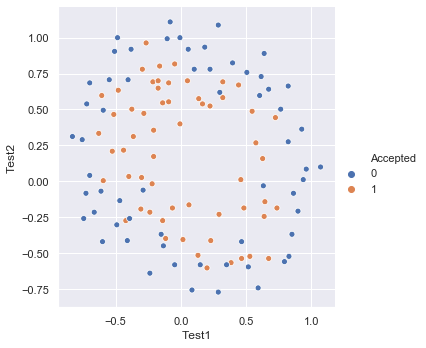

In [4]:
sns.relplot(
     x=data.columns[0],
     y=data.columns[1],
     data = data,
     hue=data.columns[-1])

The scatter plot shows that the dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straightforward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

We try anyway to apply a logistic regression and see the cross_val_score.

In [5]:
X = data.iloc[:, :-1]  # it takes all rows and only the first 2 columns
y = data.iloc[:, -1]   # it takes all rows and the last column

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, stratify =y)

In [7]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.fit_transform(X_test)
X = sc_x.fit_transform(X)

In [8]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(classifier, X, y, cv=10).mean()

0.2121212121212121

We plot the ROC curve (but the result is not good since we cannot apply the normal logistic regression in this case).

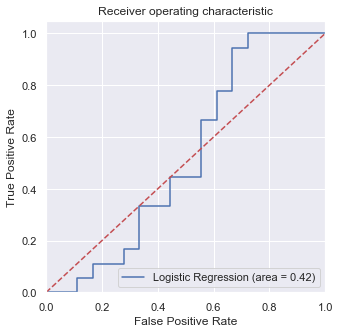

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, classifier.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

## Feature mapping

Plotting the data clearly shows that the decision boundary that separates the different classes is a non-linear one. This lead to the next step of feature mapping, where we add additional polynomial terms to try and better fit the data (normal logistic regression can only to able to fit a linear decision boundary which will not do well in this case). It is decided in the assignment that we will add polynomial terms up to the 6th power.

One way to fit the data better is to create more features from each data point, for example mapping the features into all polynomial terms of $x1$ and $x2$ up to the 6th power. As a result of this mapping, the matrix of two features (the scores on two QA tests) will be transformed into a 28-dimensional matrix. A logistic regression classifier trained on this higher-dimension feature matrix will have a more complex decision boundary and will appear nonlinear when drawn in the 2-dimensional plot. Note that while the feature mapping allows to build a more expressive classifier, it is also more susceptible to overfitting.

We use the following function to add explicative variables to our dataset.

In [11]:
import copy

def mapFeature(data, features, degree):
    """
    Feature mapping function to polynomial features.
    Maps the features to quadratic features.
    Returns a new df with more features, comprising of
    x1, x2, x1^2, x2^2, x1*x2, x1*x2^2, etc...
    Args:
        df: a pandas df with index, features and target cols
        features: int, the number of initial features
        degree: int, the polynomial degree
    Returns:
        df: a pandas df with the new features
    """
    # Create a copy of the data df.
    df = copy.deepcopy(data)
    degree = degree
    # Insert a first column with ones.
    df.insert(0, 'Ones', 1)
    x = []
    for n in range(1, features + 1):
        x.append(df.iloc[:, n])
    for i in range(1, degree + 1):
        for j in range(0, i + 1):
            df['x' + str(i) + str(j)] = np.power(x[0], i-j) * np.power(x[1], j)
    
    # Drop unnecessary columns.
    cols = [0, 1, 2]
    df.drop(df.columns[cols], axis=1, inplace=True)
    # Move target column to the end.
    # Make a list of all of the columns.
    cols = df.columns.tolist()
    # Reorder columns.
    cols = cols[1:] + [cols[0]]
    # Commit the reordering.
    df = df[cols]
    return df

The mapFeature function also adds a column of ones to X so we do not have to deal with it later on. This diagram is useful to visualize what we are doing and the polynomial terms involved.

<img src="mapfeature.png" style="width:300px"/>

In [12]:
new_features = mapFeature(data, 2, 6)
new_features

,x10,x11,x20,x21,x22,x30,x31,x32,x33,x40,...,x54,x55,x60,x61,x62,x63,x64,x65,x66,Accepted
0,0.051267,0.699560,0.002628,0.035864,0.489384,1.347453e-04,0.001839,0.025089,0.342354,6.907989e-06,...,1.227829e-02,1.675424e-01,1.815630e-08,2.477505e-07,3.380660e-06,4.613055e-05,6.294709e-04,8.589398e-03,1.172060e-01,1
1,-0.092742,0.684940,0.008601,-0.063523,0.469143,-7.976812e-04,0.005891,-0.043509,0.321335,7.397855e-05,...,-2.041205e-02,1.507518e-01,6.362953e-07,-4.699318e-06,3.470651e-05,-2.563226e-04,1.893054e-03,-1.398103e-02,1.032560e-01,1
2,-0.213710,0.692250,0.045672,-0.147941,0.479210,-9.760555e-03,0.031616,-0.102412,0.331733,2.085928e-03,...,-4.907685e-02,1.589699e-01,9.526844e-05,-3.085938e-04,9.995978e-04,-3.237900e-03,1.048821e-02,-3.397345e-02,1.100469e-01,1
3,-0.375000,0.502190,0.140625,-0.188321,0.252195,-5.273438e-02,0.070620,-0.094573,0.126650,1.977539e-02,...,-2.385083e-02,3.194040e-02,2.780914e-03,-3.724126e-03,4.987251e-03,-6.678793e-03,8.944062e-03,-1.197765e-02,1.604015e-02,1
4,-0.513250,0.465640,0.263426,-0.238990,0.216821,-1.352032e-01,0.122661,-0.111283,0.100960,6.939303e-02,...,-2.412849e-02,2.189028e-02,1.827990e-02,-1.658422e-02,1.504584e-02,-1.365016e-02,1.238395e-02,-1.123519e-02,1.019299e-02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,-0.720620,0.538740,0.519293,-0.388227,0.290241,-3.742131e-01,0.279764,-0.209153,0.156364,2.696654e-01,...,-6.070482e-02,4.538330e-02,1.400354e-01,-1.046913e-01,7.826790e-02,-5.851357e-02,4.374511e-02,-3.270412e-02,2.444980e-02,0
114,-0.593890,0.494880,0.352705,-0.293904,0.244906,-2.094682e-01,0.174547,-0.145447,0.121199,1.244011e-01,...,-3.562096e-02,2.968243e-02,4.387691e-02,-3.656200e-02,3.046659e-02,-2.538737e-02,2.115493e-02,-1.762810e-02,1.468924e-02,0
115,-0.484450,0.999270,0.234692,-0.484096,0.998541,-1.136964e-01,0.234520,-0.483743,0.997812,5.508024e-02,...,-4.830370e-01,9.963553e-01,1.292688e-02,-2.666414e-02,5.499985e-02,-1.134476e-01,2.340073e-01,-4.826843e-01,9.956280e-01,0
116,-0.006336,0.999270,0.000040,-0.006332,0.998541,-2.544062e-07,0.000040,-0.006327,0.997812,1.612020e-09,...,-6.317918e-03,9.963553e-01,6.472253e-14,-1.020695e-11,1.609667e-09,-2.538495e-07,4.003286e-05,-6.313306e-03,9.956280e-01,0


Now the number of features is:

In [13]:
new_features.shape

(118, 28)

In [14]:
new_features.head()

,x10,x11,x20,x21,x22,x30,x31,x32,x33,x40,...,x54,x55,x60,x61,x62,x63,x64,x65,x66,Accepted
0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,0.000007,...,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206,1
1,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,0.000074,...,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256,1
2,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,0.002086,...,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047,1
3,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,0.019775,...,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040,1
4,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,0.069393,...,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193,1


### Cost function and gradient

We define the sigmoid function for logistic regression:

$h(z) = \frac{1}{1 + e^{-z}} $, where $z = \theta^T \textbf{x}$

In [15]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [16]:
# Create a function to pepare the data.
def prepareData(data, n):
    """
    Add 1s column, convert to arrays,
    initialize theta.
    Args:
        data: read the data file
        n: int
    Return:
        x: a (m, n+1) array
        y: a (m, 1) array
        theta: a (n+1, 1) array
    """
    # Add a column with 1s in the data set.
    data.insert(0, 'Ones', 1)

    # Define x and y, separating the data set.
    x = data.iloc[:, 0:n+1]
    y = data.iloc[:, n+1:n+2]

    # Convert to arrays, so this function is
    # compatible with scipy.optimize.fmin later.
    # Initialize parameters theta to 0s.
    # Theta is a (n+1, 1) array,
    # where n is the number of features.
    x = np.array(x.values)
    y = np.array(y.values)
    theta = np.zeros((n+1, 1))
    return x, y, theta

We compute the cost function and gradient for regularized logistic regression. The regularized cost function in logistic regression is

$J(\theta)=\frac{1}{m} \sum_{i=1}^m[-y^{(i)} log(h_\theta (x^{(i)})-(1-y^{(i)}) log(1-h_\theta (x^{(i)}))]+\frac{\lambda}{2m} \sum_{j=1}^n\theta_j^2$

Note that the parameter $\theta_0$ should not be regularized. The gradient of the cost function is a vector where the $j^{th}$ element is defined as follows:

$\frac{\partial J(\theta)}{\partial \theta_0}=\frac{1}{m} \sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}$ for $j=0$

and

$\frac{\partial J(\theta)}{\partial \theta_j}=\frac{1}{m} \sum_{i=1}^m(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}+\frac{\lambda}{m}\theta_j$ for $j\geq1$

In [17]:
# Get the number of features.
n = len(new_features.columns)-1 # subtract the target column

x, y, theta = prepareData(new_features, n)

print('Checking the dimensions of the matrices x, y, theta...')
print(x.shape, y.shape, theta.shape)

Checking the dimensions of the matrices x, y, theta...
(118, 28) (118, 1) (28, 1)


In [18]:
# Modify the computeCost function to
# include the regularization term.
def computeCost(theta, x, y, lambda_coef):
    """
    Compute the cost function.
    Args:
        theta: array shape(n+1, 1) 
        x: array shape(m, n+1) 
        y: array shape(m, 1)
    Returns:
        cost: float
    """
    m = len(x)
    # Do matrix multiplication with numpy.dot
    h_theta = sigmoid(np.dot(x, theta))
    term1 = np.dot(-y.T, np.log(h_theta))
    term2 = np.dot((1 - y).T, np.log(1 - h_theta))
    # Exclude theta_0!!!
    reg_term = (lambda_coef / (2 * m)) * np.sum(np.square(theta[1:]))
    cost = (np.sum(term1 - term2) / m) + reg_term
    return cost

print('The cost with initial θ equals to zeros, is:')
print(computeCost(theta, x, y, 0))

The cost with initial θ equals to zeros, is:
0.6931471805599453


### Learning parameters

Similar to the previous parts, an optimize function will be used to learn the optimal parameters $\theta$.
(The *fmin* *from scipy.optimize import fmin* was tested and it was found that cannot converge.)
The alternative *minimize* function will be used.

In [19]:
from scipy.optimize import minimize

res = minimize(fun=computeCost, x0=theta, args=(x, y, 100))
print("Optimal theta parameters for lambda = 100:")
theta_opt = res.x
theta_opt

Optimal theta parameters for lambda = 100:


array([ 0.02188604, -0.01748169,  0.0057103 , -0.05516942, -0.01314888,
       -0.03859919, -0.01846357, -0.00773238, -0.00892435, -0.02280493,
       -0.04343877, -0.00235625, -0.01415632, -0.00349511, -0.04143635,
       -0.02100597, -0.00471924, -0.00359135, -0.00632237, -0.00502444,
       -0.03197708, -0.03416354, -0.00107629, -0.00702625, -0.00038507,
       -0.00798242, -0.00154779, -0.04108713])

### Plot the decision boundary

Plot the decision boundary on the training data, using the optimal $\theta$ values. Compute the classifier’s predictions on an evenly spaced grid and then draw a contour plot of where the predictions change from $y=0$ to $y=1$.

Notice the changes in the decision boundary as $\lambda$ varies. With a small $\lambda$, the classifier gets almost every training example correct, but draws a very complicated boundary, thus overfitting the data. This is not a good decision boundary: for example, it predicts that a point at $x=(−0.25,1.5)$ is accepted ($y=1$), which seems to be an incorrect decision given the training set.

With a larger $\lambda$, the plot shows a simpler decision boundary which still separates the positives and negatives fairly well. However, if $\lambda$ is set too high, the resulting fit is not good and the decision boundary will not follow the data so well, thus underfitting the data.

In [20]:
# Create a predict function.
def predictAdmission(x, theta):
    """
    Predict whether a student will be admitted.
    Args:
        x: array shape(m, n+1)
        theta: ndarray, the optimal parameters of the cost function
    Returns:
        predicted: array shape(m,) of booleans
    """
    probability = np.array(sigmoid(np.dot(x, theta)))
    predicted = probability >= 0.5
    return predicted

------------------------------------------------------------

No regularization (Overfitting) (λ = 0)
Accuracy score: 91.5%


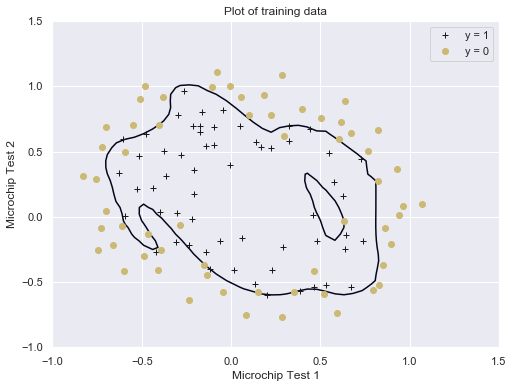

------------------------------------------------------------

Training data with decision boundary (λ = 1)
Accuracy score: 83.1%


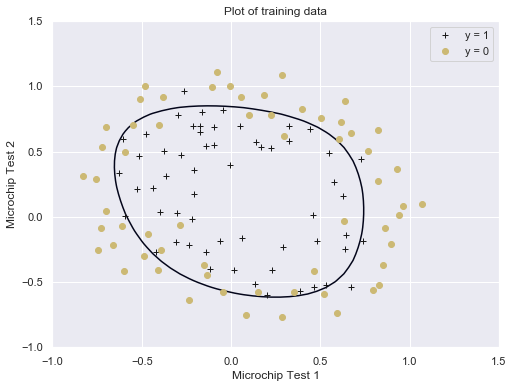

------------------------------------------------------------

Too much regularization (Underfitting) (λ = 100)
Accuracy score: 61.0%


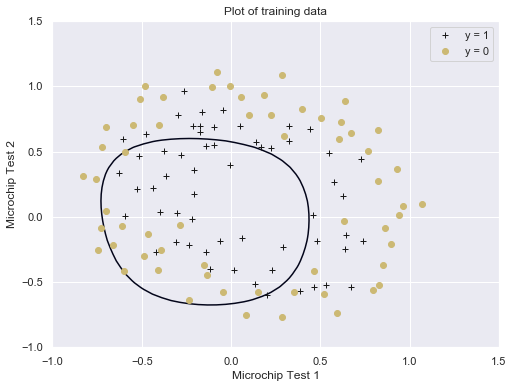

In [21]:
# Create different cases of λ to plot the decision boundaries.
cases = {"No regularization (Overfitting) (λ = 0)": 0,
         "Training data with decision boundary (λ = 1)": 1,
         "Too much regularization (Underfitting) (λ = 100)": 100}

for k, v in cases.items():
    print(60 * "-")
    print()
    print(k)
    
    # Optimize the cost function.
    res = minimize(fun=computeCost, x0=theta, args=(x, y, v))
    theta_opt = res.x
    
    # Compute the accuracy.
    predicted = predictAdmission(x, theta_opt)
    correct = np.sum(predicted.astype(int) == y.ravel())
    total = len(predicted)
    print('Accuracy score: {}%'.format(round((100 * correct / total), 1)))
    
    # Reshape theta to (n, 1).
    theta_opt = theta_opt.reshape(len(theta), 1)

    # Create the meshgrid.
    xs = np.linspace(-1, 1.5, 50)
    ys = np.linspace(-1, 1.5, 50)
    xx, yy = np.meshgrid(xs, ys)
    # Note the input to np.zeros is a tuple!!!
    zs = np.zeros((len(xs), len(ys)))

    # Create the dataframe from the above columns.
    df = pd.DataFrame({'xs': xx.ravel(),
                         'ys': yy.ravel(),
                         'zs': zs.ravel()})

    # Transform the df.
    transformed_data = mapFeature(df, 2, 6)

    # Get the number of features.
    n = len(transformed_data.columns)-1

    # Prepare the data.
    xx1, yy1, theta = prepareData(transformed_data, n)

    # Compute the classifier’s predictions.
    h_theta = sigmoid(np.dot(xx1, theta_opt))
    h_theta = h_theta.reshape((50, 50))

    plt.figure(figsize=(8, 6))
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')
    plt.title('Plot of training data')
    plt.plot(data['Test1'][data['Accepted']==1],
             data['Test2'][data['Accepted']==1], 'k+',
             label='y = 1')
    plt.plot(data['Test1'][data['Accepted']==0],
             data['Test2'][data['Accepted']==0], 'yo',
             label='y = 0')
    plt.legend()
    plt.contour(xx, yy, h_theta, [0.5])
    plt.show()